Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Examples of streaming and non streaming inference with TF/TFlite

## Prepare colab

In [1]:
# bazel build -c opt --copt=-mavx2 //kws_streaming/colab:colab_notebook.par
# ./bazel-bin/kws_streaming/colab/colab_notebook.par

## Imports

In [2]:
# TF streaming
from kws_streaming.models import models
from kws_streaming.models import utils
from kws_streaming.layers.modes import Modes

In [3]:
# general imports
from kws_streaming.layers.compat import tf
from kws_streaming.layers.compat import tf1
import matplotlib.pyplot as plt
import os
import json
import IPython
import numpy as np
import scipy as scipy
import scipy.io.wavfile as wav
import time

tf.config.threading.set_intra_op_parallelism_threads(
    num_threads = 1
)

## Load wav file

In [4]:
import scipy.signal

In [5]:
def waveread_as_pcm16(filename):
    """Read in audio data from a wav file.  Return d, sr."""
    file_handle = tf.io.gfile.GFile(filename, 'rb')
    try:
        samplerate, wave_data = wav.read(file_handle)
    finally:
        file_handle.close()  
    # Read in wav file.  
    return wave_data, samplerate  

def wavread_as_float(filename, target_sample_rate=16000):
    """Read in audio data from a wav file.  Return d, sr."""
    wave_data, samplerate = waveread_as_pcm16(filename)
    desired_length = int(
          round(float(len(wave_data)) / samplerate * target_sample_rate))
    wave_data = scipy.signal.resample(wave_data, desired_length)
    print(wave_data.shape)

    # Normalize short ints to floats in range [-1..1).
    data = np.array(wave_data, np.float32) / 32768.0
    return data, target_sample_rate

In [6]:
# Set path to wav file for testing.
wav_file = "./speech_data/five/0a2b400e_nohash_3.wav"

In [7]:
wav_data, samplerate = wavread_as_float(wav_file)

(16000,)


In [8]:
assert samplerate == 16000
IPython.display.Audio(wav_file)

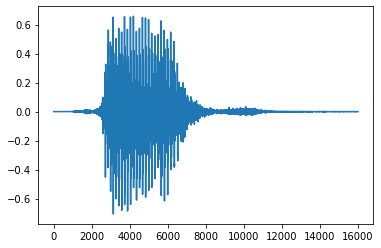

In [9]:
plt.plot(wav_data)

In [10]:
input_data = np.expand_dims(wav_data, 0)
input_data.shape

(1, 16000)

## Prepare batched model

In [11]:
import tensorflow.compat.v1 as tf2
# Start a new TensorFlow session.
tf2.reset_default_graph()
config = tf2.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf2.Session(config=config)
tf2.keras.backend.set_session(sess)

In [12]:
# Set path to model weights and model parameters
train_dir = "./training"

In [13]:
from utils import E2E_1stage_v8
from DataSettings import DataSettings
from TrainingSettings import TrainingSettings
import os
import json
from tensorflow.keras.models import model_from_json

# setting data and training
data_settings = DataSettings(
    window_size_ms = 40.0,
    window_stride_ms = 20.0,
    dct_num_features = 40,
    mel_num_bins = 80,
    mel_upper_edge_hertz = 7000,
    silence_percentage = 6.0,
    unknown_percentage = 6.0,
    wanted_words = 'on,off,up,down,zero,one,two,three,four,five,six,seven,eight,nine')

training_settings = TrainingSettings()

# create model
model_non_stream_batch = E2E_1stage_v8(input_shape=(16000), data_settings=data_settings, dropout = 0.)

# load model's weights
weights_name = 'best_weights'
model_non_stream_batch.load_weights(os.path.join(training_settings.train_dir + model_non_stream_batch.name, weights_name))

#tf.saved_model.save(model_non_stream_batch, os.path.join(train_dir + '/model'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
model_non_stream_batch.summary()

Model: "E2E_1stage_v8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
speech_features (SpeechFeatu (None, 49, 40)            0         
_________________________________________________________________
svdf_1 (Svdf)                (None, 46, 128)           44416     
_________________________________________________________________
svdf_2 (Svdf)                (None, 37, 128)           68480     
_________________________________________________________________
svdf_3 (Svdf)                (None, 28, 128)           68480     
_________________________________________________________________
svdf_4 (Svdf)                (None, 19, 128)           68480     
_________________________________________________________________
svdf_5 (Svdf)                (None, 10, 128)         

In [15]:
tf.keras.utils.plot_model(
    model_non_stream_batch,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


## Read labels

In [16]:
with open(os.path.join(training_settings.train_dir, 'labels.txt'), 'r') as fd:
    labels_txt = fd.read()

In [17]:
labels = labels_txt.split()
labels

['_silence_',
 '_unknown_',
 'on',
 'off',
 'up',
 'down',
 'zero',
 'one',
 'two',
 'three',
 'four',
 'five',
 'six',
 'seven',
 'eight',
 'nine']

## Run inference with TF

### TF Run non streaming inference

In [18]:
# convert model to inference mode with batch one
inference_batch_size = 1
tf.keras.backend.set_learning_phase(0)
data_settings.batch_size = inference_batch_size  # set batch size

model_non_stream = utils.to_streaming_inference(model_non_stream_batch, data_settings, Modes.NON_STREAM_INFERENCE)
model_non_stream.summary()

path_model = training_settings.train_dir + model_non_stream_batch.name + '/non_stream'
if not os.path.exists(path_model):
    os.makedirs(path_model)
#tf.keras.models.save_model(model_non_stream_batch, os.path.join(path_model))
#tf.saved_model.save(model_non_stream, path_model)

# serialize model to JSON
model_non_stream_json = model_non_stream.to_json()


with open(os.path.join(path_model, "model_non_stream.json"), "w") as json_file:
    json_file.write(model_non_stream_json)

model_non_stream.save_weights(path_model + '/weights')
print("Saved model to disk")

Model: "E2E_1stage_v8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_audio (InputLayer)     [(1, 16000)]              0         
_________________________________________________________________
speech_features (SpeechFeatu (1, 49, 40)               0         
_________________________________________________________________
svdf_1 (Svdf)                (1, 46, 128)              44416     
_________________________________________________________________
svdf_2 (Svdf)                (1, 37, 128)              68480     
_________________________________________________________________
svdf_3 (Svdf)                (1, 28, 128)              68480     
_________________________________________________________________
svdf_4 (Svdf)                (1, 19, 128)              68480     
_________________________________________________________________
svdf_5 (Svdf)                (1, 10, 128)            

In [19]:
# convert trained model to non streaming TFLite stateless
# to finish other tests we do not stop program if exception happen here
  # with TFLite
folder = 'tflite_non_stream'
fname = 'non_stream.tflite'
mode = Modes.NON_STREAM_INFERENCE
path_model = os.path.join(training_settings.train_dir +  model_non_stream_batch.name, folder)
if not os.path.exists(path_model):
    os.makedirs(path_model)
try:
    with open(os.path.join(path_model, fname), 'wb') as fd:
        fd.write(utils.model_to_tflite(sess, model_non_stream, data_settings, mode, path_model))
except IOError as e:
    logging.warning('FAILED to write file: %s', e)
except (ValueError, AttributeError, RuntimeError, TypeError) as e:
    logging.warning('FAILED to convert to mode %s, tflite: %s', mode, e)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


INFO:tensorflow:Froze 30 variables.


INFO:tensorflow:Froze 30 variables.


INFO:tensorflow:Converted 30 variables to const ops.


INFO:tensorflow:Converted 30 variables to const ops.


In [20]:
tf.keras.utils.plot_model(
    model_non_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [21]:
start_time = time.time()
predictions = model_non_stream.predict(input_data)
predicted_labels = np.argmax(predictions, axis=1)
end_time = time.time()
print("Predict: ", labels[predicted_labels[0]])
print("Execution time: ", end_time - start_time)

Predict:  five
Execution time:  0.5145912170410156


### TF Run streaming inference with internal state

In [22]:
# convert model to streaming mode
data_settings.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, data_settings, Modes.STREAM_INTERNAL_STATE_INFERENCE)
model_stream.summary()


path_model = training_settings.train_dir  + model_non_stream_batch.name + '/stream_state_internal'
if not os.path.exists(path_model):
    os.makedirs(path_model)
#tf.keras.models.save_model(model_non_stream_batch, os.path.join(path_model))


# serialize model to JSON
model_stream_json = model_stream.to_json()


with open(os.path.join(path_model, "model_stream_internal.json"), "w") as json_file:
    json_file.write(model_stream_json)

model_stream.save_weights(path_model + '/weights')
print("Saved model to disk")

Model: "E2E_1stage_v8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_audio (InputLayer)     [(1, 320)]                0         
_________________________________________________________________
speech_features (SpeechFeatu (1, 1, 40)                640       
_________________________________________________________________
svdf_1 (Svdf)                (1, 1, 128)               45440     
_________________________________________________________________
svdf_2 (Svdf)                (1, 1, 128)               71040     
_________________________________________________________________
svdf_3 (Svdf)                (1, 1, 128)               71040     
_________________________________________________________________
svdf_4 (Svdf)                (1, 1, 128)               71040     
_________________________________________________________________
svdf_5 (Svdf)                (1, 1, 128)             

In [23]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [24]:
# convert trained model to streaming inference with internal state TFLite stateless
# to finish other tests we do not stop program if exception happen here
# with TFLite
from absl import logging

folder = 'tflite_stream_state_internal'
fname = 'stream_state_internal.tflite'
mode = Modes.STREAM_INTERNAL_STATE_INFERENCE
path_model = os.path.join(training_settings.train_dir + '/' + model_non_stream.name , folder)
if not os.path.exists(path_model):
    os.makedirs(path_model)
try:
    with open(os.path.join(path_model, fname), 'wb') as fd:
        fd.write(utils.model_to_tflite(sess, model_non_stream, data_settings, mode, path_model))
except IOError as e:
    logging.warning('FAILED to write file: %s', e)
except (ValueError, AttributeError, RuntimeError, TypeError) as e:
    logging.warning('FAILED to convert to mode %s, tflite: %s', mode, e)

In [25]:
start_time = time.time()
# run streaming inference
start = 0
end = data_settings.window_stride_samples
while end <= input_data.shape[1]:
    stream_update = input_data[:, start:end]
    # get new frame from stream of data
    stream_output_prediction = model_stream.predict(stream_update)
    print(start/160, ": ", np.argmax(stream_output_prediction))
    stream_output_arg = np.argmax(stream_output_prediction)
    # update indexes of streamed updates
    start = end
    end = start + data_settings.window_stride_samples
end_time = time.time()
print("Predict: ", labels[stream_output_arg])
print("Execution time: ", end_time - start_time)


0.0 :  3
2.0 :  3
4.0 :  3
6.0 :  3
8.0 :  3
10.0 :  3
12.0 :  3
14.0 :  3
16.0 :  1
18.0 :  3
20.0 :  4
22.0 :  4
24.0 :  4
26.0 :  4
28.0 :  10
30.0 :  3
32.0 :  1
34.0 :  1
36.0 :  11
38.0 :  11
40.0 :  11
42.0 :  11
44.0 :  11
46.0 :  11
48.0 :  11
50.0 :  11
52.0 :  11
54.0 :  11
56.0 :  11
58.0 :  11
60.0 :  11
62.0 :  11
64.0 :  11
66.0 :  11
68.0 :  11
70.0 :  11
72.0 :  11
74.0 :  11
76.0 :  11
78.0 :  11
80.0 :  11
82.0 :  11
84.0 :  11
86.0 :  11
88.0 :  11
90.0 :  11
92.0 :  11
94.0 :  11
96.0 :  11
98.0 :  11
Predict:  five
Execution time:  0.9947595596313477


### TF Run streaming inference with external state

In [26]:
# convert model to streaming mode
data_settings.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, data_settings, Modes.STREAM_EXTERNAL_STATE_INFERENCE)
#model_stream.summary()

path_model = training_settings.train_dir  + model_non_stream_batch.name + '/stream_state_external'
if not os.path.exists(path_model):
    os.makedirs(path_model)
#tf.keras.models.save_model(model_non_stream_batch, os.path.join(path_model))
# serialize model to JSON
model_stream_json = model_stream.to_json()


with open(os.path.join(path_model, "model_stream_external.json"), "w") as json_file:
    json_file.write(model_stream_json)

model_stream.save_weights(path_model + '/weights')
print("Saved model to disk")

Saved model to disk


In [27]:
# convert trained model to streaming inference with internal state TFLite stateless
# to finish other tests we do not stop program if exception happen here
# with TFLite
from absl import logging

folder = 'tflite_stream_state_external'
fname = 'stream_state_external.tflite'
mode = Modes.STREAM_EXTERNAL_STATE_INFERENCE
path_model = os.path.join(training_settings.train_dir + '/' + model_non_stream.name , folder)
if not os.path.exists(path_model):
    os.makedirs(path_model)
try:
    with open(os.path.join(path_model, fname), 'wb') as fd:
        fd.write(utils.model_to_tflite(sess, model_non_stream, data_settings, mode, path_model))
except IOError as e:
    logging.warning('FAILED to write file: %s', e)
except (ValueError, AttributeError, RuntimeError, TypeError) as e:
    logging.warning('FAILED to convert to mode %s, tflite: %s', mode, e)

INFO:tensorflow:Froze 30 variables.


INFO:tensorflow:Froze 30 variables.


INFO:tensorflow:Converted 30 variables to const ops.


INFO:tensorflow:Converted 30 variables to const ops.


In [28]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [29]:
start_time = time.time()
inputs = []
for s in range(len(model_stream.inputs)):
    inputs.append(np.zeros(model_stream.inputs[s].shape, dtype=np.float32))

reset_state = True

if reset_state:
    for s in range(len(model_stream.inputs)):
        inputs[s] = np.zeros(model_stream.inputs[s].shape, dtype=np.float32)

start = 0
end = data_settings.window_stride_samples
while end <= input_data.shape[1]:
    # get new frame from stream of data
    stream_update = input_data[:, start:end]
    
    # update indexes of streamed updates
    start = end
    end = start + data_settings.window_stride_samples
    
    # set input audio data (by default input data at index 0)
    inputs[0] = stream_update
    
    
    # run inference
    outputs = model_stream.predict(inputs)
    
    
    # get output states and set it back to input states
    # which will be fed in the next inference cycle
    for s in range(1, len(model_stream.inputs)):
        inputs[s] = outputs[s]
    
    stream_output_arg = np.argmax(outputs[0])
    
end_time = time.time()

print("Predict: ", labels[stream_output_arg])
print("Execution time: ", end_time - start_time)

Predict:  five
Execution time:  1.432680368423462


##Run inference with TFlite

### Run non streaming inference with TFLite

In [30]:
path = os.path.join(training_settings.train_dir + model_non_stream_batch.name, 'tflite_non_stream')
tflite_model_name = 'non_stream.tflite'

In [31]:
# prepare TFLite interpreter
with open(os.path.join(path, tflite_model_name), 'rb') as f:
  model_content = f.read()

interpreter = tf.lite.Interpreter(model_content=model_content)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inputs = []
for s in range(len(input_details)):
  inputs.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

In [32]:
padded_input = np.zeros((1, 16000), dtype=np.float32)
padded_input[:, :input_data.shape[1]] = input_data

In [33]:
# set input audio data (by default input data at index 0)
interpreter.set_tensor(input_details[0]['index'], padded_input.astype(np.float32))

# run inference
interpreter.invoke()

# get output: classification
out_tflite = interpreter.get_tensor(output_details[0]['index'])

out_tflite_argmax = np.argmax(out_tflite)

out_tflite_argmax

11

In [34]:
print(out_tflite)

[[-86.36789      0.45005324 -13.18658    -10.869619   -12.377458
  -14.9704895  -12.572383    -7.1404333  -17.053265   -14.066227
   -8.581641    12.359663   -11.551639   -22.44075     -7.364015
  -12.960085  ]]


In [35]:
labels[out_tflite_argmax]

'five'

### Run streaming inference with TFLite

In [36]:
print(labels)

['_silence_', '_unknown_', 'on', 'off', 'up', 'down', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']


In [37]:
path = os.path.join(training_settings.train_dir  + model_non_stream.name, 'tflite_stream_state_external')
tflite_model_name = 'stream_state_external.tflite'

In [38]:
with open(os.path.join(path , tflite_model_name), 'rb') as f:
  model_content = f.read()

interpreter = tf.lite.Interpreter(model_content=model_content)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inputs = []
for s in range(len(input_details)):
  inputs.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

In [39]:
input_details[0]['shape']

array([  1, 320], dtype=int32)

In [40]:
reset_state = True

# before processing new test sequence we can reset model state
# if we reset model state then it is not real streaming mode
if reset_state:
  for s in range(len(input_details)):
    print(input_details[s]['shape'])
    inputs[s] = np.zeros(input_details[s]['shape'], dtype=np.float32)

start = 0
end = data_settings.window_stride_samples
while end <= input_data.shape[1]:
  stream_update = input_data[:, start:end]
  stream_update = stream_update.astype(np.float32)

  # update indexes of streamed updates
  start = end
  end = start + data_settings.window_stride_samples

  # set input audio data (by default input data at index 0)
  interpreter.set_tensor(input_details[0]['index'], stream_update)

  # set input states (index 1...)
  for s in range(1, len(input_details)):
    interpreter.set_tensor(input_details[s]['index'], inputs[s])

  # run inference
  interpreter.invoke()

  # get output: classification
  out_tflite = interpreter.get_tensor(output_details[0]['index'])
  print(start / 16000.0, np.argmax(out_tflite), np.max(out_tflite))

  # get output states and set it back to input states
  # which will be fed in the next inference cycle
  for s in range(1, len(input_details)):
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    inputs[s] = interpreter.get_tensor(output_details[s]['index'])

  out_tflite_argmax = np.argmax(out_tflite)
out_tflite_argmax  

[  1 320]
[  1 640]
[  1   4 256]
[  1  10 256]
[  1  10 256]
[  1  10 256]
[  1  10 256]
[  1  10 256]
[  1   1 256]
0.02 3 -0.8609636
0.04 3 -0.89564687
0.06 3 -0.96874756
0.08 3 -0.798247
0.1 3 -0.94578785
0.12 3 -0.16323563
0.14 3 1.0993431
0.16 3 0.9256642
0.18 1 -0.4477975
0.2 3 0.66976726
0.22 4 0.84120005
0.24 4 0.89539385
0.26 4 1.289984
0.28 4 1.1006248
0.3 10 2.468081
0.32 3 2.0576494
0.34 1 2.0553384
0.36 1 2.903261
0.38 11 6.7793775
0.4 11 9.922297
0.42 11 12.723738
0.44 11 13.598956
0.46 11 14.367258
0.48 11 16.461714
0.5 11 17.205446
0.52 11 16.42032
0.54 11 16.568892
0.56 11 15.409333
0.58 11 14.774759
0.6 11 14.603228
0.62 11 15.899981
0.64 11 15.757044
0.66 11 14.828158
0.68 11 14.594707
0.7 11 15.051089
0.72 11 16.287043
0.74 11 15.8543625
0.76 11 16.982382
0.78 11 17.358429
0.8 11 17.473585
0.82 11 16.924444
0.84 11 15.999374
0.86 11 15.307756
0.88 11 15.870745
0.9 11 15.615446
0.92 11 14.734558
0.94 11 13.464455
0.96 11 13.1654215
0.98 11 13.335947
1.0 11 12.359658

11

In [41]:
print(out_tflite)

[[-86.36786      0.45004913 -13.186575   -10.86961    -12.377452
  -14.970488   -12.5723715   -7.1404257  -17.053251   -14.066226
   -8.581637    12.359658   -11.551635   -22.440748    -7.3640122
  -12.960087  ]]


In [42]:
labels[out_tflite_argmax]

'five'